# Phase 2: Enhanced CodeT5 with Dual-Encoder Architecture + Reinforcement Learning

**Research Project**: Enhanced Kubernetes Configuration Generation through Dual-Encoder CodeT5

**Phase**: 2 - Enhanced Architecture Implementation (Weeks 5-6)

**Objectives**:
1. Implement dual-encoder architecture (Intent + K8s Pattern encoders)
2. Add RL optimization using BP% as primary reward signal
3. Comparative evaluation: Baseline vs Enhanced model
4. Achieve targets: CodeBLEU ≥85%, BP% ≥90%, Quality ≥85/100

**Building on**:
- Baseline: CodeBLEU 83.43%, YAML Validity 90.62%, BP% ~55%
- Phase 1: Best Practices Analyzer (11 checks), Feedback System

---

## 1. Environment Setup & Dependencies

In [2]:
# Install required packages
#!pip install transformers==4.30.0 torch==2.0.1 datasets==2.12.0
#!pip install pyyaml==6.0 rouge-score==0.1.2 nltk==3.8.1
#!pip install sacrebleu==2.3.1 evaluate==0.4.0
#!pip install codebleu==0.1.1  # For CodeBLEU evaluation
#!pip install tensorboard==2.13.0  # For training visualization

!pip install transformers torch datasets pyyaml rouge-score nltk sacrebleu evaluate codebleu tensorboard

# Download NLTK data
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.2/546.2 kB 18.6 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=ac365c777b869f905423c81cb9397508ffae31c09289224e9ed8a00b6416b7d5
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths
PROJECT_ROOT = '/content/drive/MyDrive/ravali/thesis-research'
BASELINE_MODEL_PATH = f'{PROJECT_ROOT}/results/baseline_model'
ENHANCED_MODEL_PATH = f'{PROJECT_ROOT}/results/enhanced_model'
DATA_PATH = f'{PROJECT_ROOT}/data'
RESULTS_PATH = f'{PROJECT_ROOT}/results/phase2'

# Create directories
!mkdir -p {ENHANCED_MODEL_PATH}
!mkdir -p {RESULTS_PATH}

Mounted at /content/drive


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    T5Config,
    get_linear_schedule_with_warmup
)
# Corrected import: AdamW is now part of torch.optim
from torch.optim import AdamW

# Import BaseModelOutput for wrapping encoder states during generation
from transformers.modeling_outputs import BaseModelOutput

import yaml
import json
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


## 2. Load Phase 1 Components

We'll import the Best Practices Analyzer from Phase 1 to use as part of the reward function.

In [7]:
# Best Practices Analyzer from Phase 1
class KubernetesBestPracticesAnalyzer:
    """Analyzes Kubernetes YAML against 11 critical best practices.

    This is imported from Phase 1 (T5_Phase1_Feedback_System_v1.ipynb)
    and used in the RL reward function.
    """

    def __init__(self):
        self.best_practices = [
            'namespace',
            'labels',
            'resources',
            'probes',
            'security_context',
            'readonly_fs',
            'capabilities',
            'image_tag',
            'service_account',
            'network_policy',
            'pod_security'
        ]

    def check_namespace(self, yaml_dict):
        """Check if namespace is defined."""
        return yaml_dict.get('metadata', {}).get('namespace') is not None

    def check_labels(self, yaml_dict):
        """Check for proper labels (app, version, component)."""
        labels = yaml_dict.get('metadata', {}).get('labels', {})
        return 'app' in labels or 'version' in labels or 'component' in labels

    def check_resources(self, yaml_dict):
        """Check for resource limits and requests."""
        if yaml_dict.get('kind') != 'Deployment':
            return True  # Only check Deployments

        containers = yaml_dict.get('spec', {}).get('template', {}).get('spec', {}).get('containers', [])
        for container in containers:
            resources = container.get('resources', {})
            if not resources.get('limits') or not resources.get('requests'):
                return False
        return len(containers) > 0

    def check_probes(self, yaml_dict):
        """Check for liveness and readiness probes."""
        if yaml_dict.get('kind') != 'Deployment':
            return True

        containers = yaml_dict.get('spec', {}).get('template', {}).get('spec', {}).get('containers', [])
        for container in containers:
            if not container.get('livenessProbe') or not container.get('readinessProbe'):
                return False
        return len(containers) > 0

    def check_security_context(self, yaml_dict):
        """Check for security context (runAsNonRoot)."""
        if yaml_dict.get('kind') != 'Deployment':
            return True

        security_context = yaml_dict.get('spec', {}).get('template', {}).get('spec', {}).get('securityContext', {})
        return security_context.get('runAsNonRoot') == True

    def check_readonly_fs(self, yaml_dict):
        """Check for read-only root filesystem."""
        if yaml_dict.get('kind') != 'Deployment':
            return True

        containers = yaml_dict.get('spec', {}).get('template', {}).get('spec', {}).get('containers', [])
        for container in containers:
            sec_ctx = container.get('securityContext', {})
            if not sec_ctx.get('readOnlyRootFilesystem'):
                return False
        return len(containers) > 0

    def check_capabilities(self, yaml_dict):
        """Check if dangerous capabilities are dropped."""
        if yaml_dict.get('kind') != 'Deployment':
            return True

        containers = yaml_dict.get('spec', {}).get('template', {}).get('spec', {}).get('containers', [])
        for container in containers:
            sec_ctx = container.get('securityContext', {})
            caps = sec_ctx.get('capabilities', {})
            if not caps.get('drop'):
                return False
        return len(containers) > 0

    def check_image_tag(self, yaml_dict):
        """Check that image doesn't use :latest tag."""
        if yaml_dict.get('kind') != 'Deployment':
            return True

        containers = yaml_dict.get('spec', {}).get('template', {}).get('spec', {}).get('containers', [])
        for container in containers:
            image = container.get('image', '')
            if ':latest' in image or ':' not in image:
                return False
        return len(containers) > 0

    def check_service_account(self, yaml_dict):
        """Check if custom service account is defined."""
        if yaml_dict.get('kind') != 'Deployment':
            return True

        service_account = yaml_dict.get('spec', {}).get('template', {}).get('spec', {}).get('serviceAccountName')
        return service_account is not None and service_account != 'default'

    def check_network_policy(self, yaml_dict):
        """For NetworkPolicy resources, check basic structure."""
        if yaml_dict.get('kind') == 'NetworkPolicy':
            return 'spec' in yaml_dict and 'podSelector' in yaml_dict.get('spec', {})
        return True  # Pass for non-NetworkPolicy resources

    def check_pod_security(self, yaml_dict):
        """Check for pod security standards compliance."""
        if yaml_dict.get('kind') != 'Deployment':
            return True

        pod_spec = yaml_dict.get('spec', {}).get('template', {}).get('spec', {})
        # Check for hostNetwork, hostPID, hostIPC - should all be false or absent
        dangerous = pod_spec.get('hostNetwork') or pod_spec.get('hostPID') or pod_spec.get('hostIPC')
        return not dangerous

    def analyze(self, yaml_content):
        """Analyze YAML against all best practices.

        Returns:
            dict: {
                'checks': {practice: bool},
                'passed': int,
                'total': int,
                'percentage': float,
                'score': float  # 0-100
            }
        """
        try:
            if isinstance(yaml_content, str):
                yaml_dict = yaml.safe_load(yaml_content)
            else:
                yaml_dict = yaml_content

            if not yaml_dict or not isinstance(yaml_dict, dict):
                return self._empty_result()

            checks = {}
            checks['namespace'] = self.check_namespace(yaml_dict)
            checks['labels'] = self.check_labels(yaml_dict)
            checks['resources'] = self.check_resources(yaml_dict)
            checks['probes'] = self.check_probes(yaml_dict)
            checks['security_context'] = self.check_security_context(yaml_dict)
            checks['readonly_fs'] = self.check_readonly_fs(yaml_dict)
            checks['capabilities'] = self.check_capabilities(yaml_dict)
            checks['image_tag'] = self.check_image_tag(yaml_dict)
            checks['service_account'] = self.check_service_account(yaml_dict)
            checks['network_policy'] = self.check_network_policy(yaml_dict)
            checks['pod_security'] = self.check_pod_security(yaml_dict)

            passed = sum(checks.values())
            total = len(checks)
            percentage = (passed / total) * 100

            return {
                'checks': checks,
                'passed': passed,
                'total': total,
                'percentage': percentage,
                'score': percentage  # Normalized to 0-100
            }

        except Exception as e:
            print(f"Error analyzing YAML: {e}")
            return self._empty_result()

    def _empty_result(self):
        return {
            'checks': {bp: False for bp in self.best_practices},
            'passed': 0,
            'total': len(self.best_practices),
            'percentage': 0.0,
            'score': 0.0
        }

# Initialize analyzer
bp_analyzer = KubernetesBestPracticesAnalyzer()
print("✓ Best Practices Analyzer loaded from Phase 1")

✓ Best Practices Analyzer loaded from Phase 1


## 3. Dual-Encoder Architecture

### Architecture Design:

```
Natural Language Intent → [Intent Encoder] ─┐
                                             ├→ [Unified Decoder] → Kubernetes YAML
K8s Pattern Context    → [K8s Encoder]    ─┘
```

**Key Innovation**: Two specialized encoders that:
1. **Intent Encoder**: Processes natural language deployment requirements
2. **K8s Pattern Encoder**: Processes Kubernetes configuration patterns and syntax
3. **Attention Fusion**: Combines both representations for the decoder

In [26]:
class DualEncoderCodeT5(nn.Module):
    """
    Enhanced CodeT5 with Dual-Encoder Architecture.

    Architecture:
    - Intent Encoder: CodeT5 encoder for natural language intent
    - K8s Pattern Encoder: Separate CodeT5 encoder for Kubernetes patterns
    - Attention Fusion Layer: Combines both encoder outputs
    - Unified Decoder: Standard CodeT5 decoder

    This architecture improves intent-configuration alignment compared to
    single-encoder baseline.
    """

    def __init__(self, base_model_name='Salesforce/codet5-base'):
        super().__init__()

        # Load base CodeT5 model and config
        self.config = T5Config.from_pretrained(base_model_name)
        # Store the full T5 model to use its generate method
        self.t5_model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name)

        # Intent Encoder - processes natural language requirements
        self.intent_encoder = self.t5_model.encoder

        # K8s Pattern Encoder - processes Kubernetes configuration patterns
        # Initialize as a copy of the intent encoder
        from copy import deepcopy
        self.k8s_encoder = deepcopy(self.t5_model.encoder)

        # Decoder - unified decoder that receives fused encoder outputs
        self.decoder = self.t5_model.decoder
        self.lm_head = self.t5_model.lm_head

        # Attention Fusion Layer - combines both encoder outputs
        hidden_size = self.config.d_model
        self.fusion_attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        # Projection layers for combining encoders
        self.intent_projection = nn.Linear(hidden_size, hidden_size)
        self.k8s_projection = nn.Linear(hidden_size, hidden_size)
        self.fusion_projection = nn.Linear(hidden_size * 2, hidden_size)

        # Layer norm for stability
        self.fusion_norm = nn.LayerNorm(hidden_size)

        print("✓ Dual-Encoder Architecture initialized")
        print(f"  - Intent Encoder: {sum(p.numel() for p in self.intent_encoder.parameters())/1e6:.1f}M params")
        print(f"  - K8s Encoder: {sum(p.numel() for p in self.k8s_encoder.parameters())/1e6:.1f}M params")
        print(f"  - Decoder: {sum(p.numel() for p in self.decoder.parameters())/1e6:.1f}M params")
        print(f"  - Total: {sum(p.numel() for p in self.parameters())/1e6:.1f}M params")

    def forward(
        self,
        intent_input_ids,
        intent_attention_mask,
        k8s_input_ids,
        k8s_attention_mask,
        labels=None,
        decoder_attention_mask=None
    ):
        """
        Forward pass through dual-encoder architecture.

        Args:
            intent_input_ids: Tokenized natural language intent
            intent_attention_mask: Attention mask for intent
            k8s_input_ids: Tokenized K8s pattern context
            k8s_attention_mask: Attention mask for K8s patterns
            labels: Target YAML tokens (for training)
            decoder_attention_mask: Decoder attention mask

        Returns:
            dict with 'loss' and 'logits'
        """

        # Encode intent
        intent_outputs = self.intent_encoder(
            input_ids=intent_input_ids,
            attention_mask=intent_attention_mask,
            return_dict=True
        )
        intent_hidden = intent_outputs.last_hidden_state

        # Encode K8s patterns
        k8s_outputs = self.k8s_encoder(
            input_ids=k8s_input_ids,
            attention_mask=k8s_attention_mask,
            return_dict=True
        )
        k8s_hidden = k8s_outputs.last_hidden_state

        # Fuse encoder outputs
        fused_hidden = self._fuse_encoders(
            intent_hidden,
            k8s_hidden,
            intent_attention_mask,
            k8s_attention_mask
        )

        # Create combined attention mask
        batch_size = intent_input_ids.shape[0]
        combined_mask = torch.cat([
            intent_attention_mask,
            k8s_attention_mask
        ], dim=1)

        # Decode
        # The `decoder` expects an attention mask that matches the combined encoder output
        decoder_outputs = self.decoder(
            input_ids=labels[:, :-1] if labels is not None else None,
            encoder_hidden_states=fused_hidden,
            encoder_attention_mask=combined_mask, # Pass combined_mask here
            return_dict=True
        )

        # Generate logits
        logits = self.lm_head(decoder_outputs.last_hidden_state)

        # Compute loss if labels provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(
                logits.view(-1, logits.size(-1)),
                labels[:, 1:].reshape(-1)
            )

        return {
            'loss': loss,
            'logits': logits
        }

    def _fuse_encoders(self, intent_hidden, k8s_hidden, intent_mask, k8s_mask):
        """
        Fuse intent and K8s encoder outputs using attention mechanism.

        Strategy:
        1. Project both encoder outputs
        2. Apply cross-attention between them
        3. Concatenate and project to final representation
        """
        # Project encoder outputs
        intent_proj = self.intent_projection(intent_hidden)
        k8s_proj = self.k8s_projection(k8s_hidden)

        # Apply cross-attention: intent attends to K8s patterns
        # Ensure consistent padding mask usage
        attended, _ = self.fusion_attention(
            query=intent_proj,
            key=k8s_proj,
            value=k8s_proj,
            key_padding_mask=(~k8s_mask.bool()) # Invert mask for MultiheadAttention (True means masked)
        )

        # Concatenate intent and attended K8s representations
        combined = torch.cat([intent_proj, attended], dim=-1)

        # Project to final dimension
        fused = self.fusion_projection(combined)
        fused = self.fusion_norm(fused)

        # Concatenate both encoder outputs for decoder
        # This gives decoder access to both intent and K8s patterns
        final_hidden = torch.cat([fused, k8s_hidden], dim=1)

        return final_hidden

    def generate(
        self,
        intent_input_ids,
        intent_attention_mask,
        k8s_input_ids,
        k8s_attention_mask,
        max_length=512,
        num_beams=4,
        early_stopping=True,
        **kwargs
    ):
        """
        Generate Kubernetes YAML from intent and K8s pattern inputs.
        """
        # Encode both inputs
        intent_outputs = self.intent_encoder(
            input_ids=intent_input_ids,
            attention_mask=intent_attention_mask,
            return_dict=True
        )
        intent_hidden = intent_outputs.last_hidden_state

        k8s_outputs = self.k8s_encoder(
            input_ids=k8s_input_ids,
            attention_mask=k8s_attention_mask,
            return_dict=True
        )
        k8s_hidden = k8s_outputs.last_hidden_state

        # Fuse encoders
        fused_hidden = self._fuse_encoders(
            intent_hidden,
            k8s_hidden,
            intent_attention_mask,
            k8s_attention_mask
        )

        # Combined attention mask for the fused encoder output
        combined_mask = torch.cat([
            intent_attention_mask,
            k8s_attention_mask
        ], dim=1)

        # Wrap fused_hidden into BaseModelOutput for compatibility with .generate()
        # The generate method of AutoModelForSeq2SeqLM expects encoder_outputs to be a BaseModelOutput
        # if a custom encoder output is provided.
        encoder_outputs_for_generation = BaseModelOutput(last_hidden_state=fused_hidden)

        # Generate using the full T5 model's generate method
        generated_ids = self.t5_model.generate(
            encoder_outputs=encoder_outputs_for_generation,
            attention_mask=combined_mask, # This will be used as encoder_attention_mask
            max_length=max_length,
            num_beams=num_beams,
            early_stopping=early_stopping,
            **kwargs # Pass any additional generation arguments
        )

        return generated_ids

## 4. Data Preparation for Dual-Encoder Training

We need to prepare two inputs for each training example:
1. **Intent Input**: Natural language description
2. **K8s Pattern Input**: Kubernetes pattern template or context

In [9]:
class DualEncoderDataset(Dataset):
    """
    Dataset for dual-encoder training.

    Each sample contains:
    - intent: Natural language deployment requirement
    - k8s_pattern: Kubernetes configuration pattern/template
    - target_yaml: Ground truth Kubernetes YAML
    """

    def __init__(self, data_path, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Load training data
        with open(data_path, 'r') as f:
            self.data = json.load(f)

        print(f"Loaded {len(self.data)} training examples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Intent input (natural language)
        intent = item['intent']
        intent_encoding = self.tokenizer(
            intent,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # K8s pattern input
        # Extract kind and basic structure as pattern
        k8s_pattern = self._extract_k8s_pattern(item['yaml'])
        k8s_encoding = self.tokenizer(
            k8s_pattern,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Target YAML
        target_encoding = self.tokenizer(
            item['yaml'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'intent_input_ids': intent_encoding['input_ids'].squeeze(),
            'intent_attention_mask': intent_encoding['attention_mask'].squeeze(),
            'k8s_input_ids': k8s_encoding['input_ids'].squeeze(),
            'k8s_attention_mask': k8s_encoding['attention_mask'].squeeze(),
            'labels': target_encoding['input_ids'].squeeze(),
            'target_yaml': item['yaml']  # Keep for evaluation
        }

    def _extract_k8s_pattern(self, yaml_str):
        """
        Extract Kubernetes pattern template from full YAML.

        Strategy: Create a simplified template that captures:
        - Resource kind
        - Basic structure
        - Common field names

        This helps the K8s encoder learn configuration patterns.
        """
        try:
            yaml_dict = yaml.safe_load(yaml_str)

            kind = yaml_dict.get('kind', 'Unknown')
            api_version = yaml_dict.get('apiVersion', 'v1')

            # Build pattern based on kind
            if kind == 'Deployment':
                pattern = f"""
apiVersion: {api_version}
kind: {kind}
metadata:
  name: <NAME>
  namespace: <NAMESPACE>
  labels: <LABELS>
spec:
  replicas: <REPLICAS>
  selector:
    matchLabels: <LABELS>
  template:
    metadata:
      labels: <LABELS>
    spec:
      containers:
      - name: <CONTAINER_NAME>
        image: <IMAGE>
        ports: <PORTS>
        resources: <RESOURCES>
        livenessProbe: <PROBE>
        readinessProbe: <PROBE>
        securityContext: <SECURITY>
"""
            elif kind == 'Service':
                pattern = f"""
apiVersion: {api_version}
kind: {kind}
metadata:
  name: <NAME>
  namespace: <NAMESPACE>
spec:
  type: <SERVICE_TYPE>
  selector: <SELECTOR>
  ports: <PORTS>
"""
            else:
                pattern = f"apiVersion: {api_version}\nkind: {kind}\nmetadata: <METADATA>\nspec: <SPEC>"

            return pattern.strip()

        except:
            return "kind: Unknown"

print("✓ Dual-Encoder Dataset class defined")

✓ Dual-Encoder Dataset class defined


## 5. Reinforcement Learning Optimization

### Reward Function (from Professor Meeting Nov 06):

```python
reward = 0.3 * CodeBLEU + 0.4 * BP% + 0.2 * Security + 0.1 * Complexity
```

**Key Insight**: BP% weighted highest (40%) because it captures security, reliability, and operational readiness.

In [10]:
class RewardCalculator:
    """
    Computes multi-dimensional reward for RL optimization.

    Reward Function:
        R = 0.3 * CodeBLEU + 0.4 * BP% + 0.2 * Security + 0.1 * Complexity

    Weights based on professor feedback (Nov 06 meeting):
    - BP%: 40% (highest) - captures production readiness
    - CodeBLEU: 30% - measures generation quality
    - Security: 20% - critical for production
    - Complexity: 10% - lower weight, quality over simplicity
    """

    def __init__(self):
        self.bp_analyzer = KubernetesBestPracticesAnalyzer()

        # Import codebleu for evaluation
        try:
            from codebleu import calc_codebleu
            self.calc_codebleu = calc_codebleu
        except:
            print("Warning: codebleu not available, using approximate BLEU")
            self.calc_codebleu = None

    def compute_reward(self, generated_yaml, ground_truth_yaml):
        """
        Compute comprehensive reward signal.

        Args:
            generated_yaml: YAML string generated by model
            ground_truth_yaml: Reference YAML string

        Returns:
            dict: {
                'total_reward': float (0-1),
                'codebleu_score': float,
                'bp_score': float,
                'security_score': float,
                'complexity_score': float
            }
        """
        # 1. CodeBLEU Score (30%)
        codebleu_score = self._compute_codebleu(generated_yaml, ground_truth_yaml)

        # 2. Best Practices Score (40%) - KEY METRIC
        bp_result = self.bp_analyzer.analyze(generated_yaml)
        bp_score = bp_result['percentage'] / 100.0  # Normalize to 0-1

        # 3. Security Score (20%)
        security_score = self._compute_security_score(generated_yaml, bp_result)

        # 4. Complexity Score (10%)
        complexity_score = self._compute_complexity_score(generated_yaml)

        # Compute weighted total reward
        total_reward = (
            0.3 * codebleu_score +
            0.4 * bp_score +
            0.2 * security_score +
            0.1 * complexity_score
        )

        return {
            'total_reward': total_reward,
            'codebleu_score': codebleu_score,
            'bp_score': bp_score,
            'bp_percentage': bp_result['percentage'],
            'security_score': security_score,
            'complexity_score': complexity_score
        }

    def _compute_codebleu(self, generated, reference):
        """Compute CodeBLEU score."""
        try:
            if self.calc_codebleu:
                result = self.calc_codebleu(
                    [reference],
                    [generated],
                    lang='yaml'
                )
                return result['codebleu']
            else:
                # Fallback: simple token overlap
                gen_tokens = set(generated.split())
                ref_tokens = set(reference.split())
                if not ref_tokens:
                    return 0.0
                overlap = len(gen_tokens & ref_tokens) / len(ref_tokens)
                return min(overlap, 1.0)
        except:
            return 0.0

    def _compute_security_score(self, yaml_str, bp_result):
        """
        Compute security score based on security-related best practices.

        Security checks:
        - Security context (runAsNonRoot)
        - Read-only filesystem
        - Dropped capabilities
        - No :latest tags
        - Pod security (no hostNetwork, etc.)
        """
        security_checks = [
            'security_context',
            'readonly_fs',
            'capabilities',
            'image_tag',
            'pod_security'
        ]

        passed = sum(
            bp_result['checks'].get(check, False)
            for check in security_checks
        )

        return passed / len(security_checks)

    def _compute_complexity_score(self, yaml_str):
        """
        Compute inverse complexity score.
        Lower complexity = higher score.

        Measures:
        - Number of lines
        - Nesting depth
        - Number of fields
        """
        try:
            yaml_dict = yaml.safe_load(yaml_str)
            if not yaml_dict:
                return 0.0

            # Count lines
            lines = len(yaml_str.strip().split('\n'))

            # Estimate nesting depth
            max_depth = self._get_max_depth(yaml_dict)

            # Normalize scores (inverse for complexity)
            # Target: 20-50 lines, depth 3-5
            line_score = 1.0 if 20 <= lines <= 50 else max(0, 1.0 - abs(lines - 35) / 50)
            depth_score = 1.0 if 3 <= max_depth <= 5 else max(0, 1.0 - abs(max_depth - 4) / 5)

            return (line_score + depth_score) / 2

        except:
            return 0.0

    def _get_max_depth(self, obj, current_depth=0):
        """Recursively compute maximum nesting depth."""
        if not isinstance(obj, dict):
            return current_depth

        if not obj:
            return current_depth + 1

        return max(
            self._get_max_depth(v, current_depth + 1)
            for v in obj.values()
        )

# Initialize reward calculator
reward_calculator = RewardCalculator()
print("✓ RL Reward Calculator initialized")
print("  Reward weights: CodeBLEU=30%, BP=40%, Security=20%, Complexity=10%")

✓ RL Reward Calculator initialized
  Reward weights: CodeBLEU=30%, BP=40%, Security=20%, Complexity=10%


In [31]:
class PolicyGradientTrainer:
    """
    RL Trainer using Policy Gradient (REINFORCE algorithm).

    Training loop:
    1. Generate YAML from model
    2. Compute reward signal
    3. Update model to maximize expected reward
    4. Repeat

    This optimizes the model beyond supervised learning to maximize
    domain-specific quality metrics.
    """

    def __init__(
        self,
        model,
        tokenizer,
        reward_calculator,
        learning_rate=1e-5,
        gamma=0.99  # Discount factor
    ):
        self.model = model
        self.tokenizer = tokenizer
        self.reward_calculator = reward_calculator
        self.gamma = gamma

        # Optimizer for RL fine-tuning
        self.optimizer = AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=0.01
        )

        # Metrics tracking
        self.episode_rewards = []
        self.episode_bp_scores = []

    def train_episode(self, intent_batch, k8s_batch, target_batch):
        """
        Train one RL episode (batch).

        Args:
            intent_batch: Intent input IDs and masks
            k8s_batch: K8s pattern input IDs and masks
            target_batch: Ground truth YAML strings

        Returns:
            dict with episode metrics
        """
        self.model.train()

        # Generate YAML from current policy
        with torch.no_grad():
            generated_ids = self.model.generate(
                intent_input_ids=intent_batch['input_ids'],
                intent_attention_mask=intent_batch['attention_mask'],
                k8s_input_ids=k8s_batch['input_ids'],
                k8s_attention_mask=k8s_batch['attention_mask'],
                max_length=512,
                num_beams=2,  # Faster for RL training
                early_stopping=True
            )

        # Decode generated YAML
        generated_yamls = [
            self.tokenizer.decode(ids, skip_special_tokens=True)
            for ids in generated_ids
        ]

        # Compute rewards for each generated YAML
        rewards = []
        bp_scores = []

        for gen_yaml, target_yaml in zip(generated_yamls, target_batch):
            reward_dict = self.reward_calculator.compute_reward(gen_yaml, target_yaml)
            rewards.append(reward_dict['total_reward'])
            bp_scores.append(reward_dict['bp_percentage'])

        # Convert to tensor
        rewards_tensor = torch.tensor(rewards, device=device)

        # Compute policy gradient loss
        # Forward pass to get log probabilities
        # Ensure labels length matches logits length by slicing generated_ids
        outputs = self.model(
            intent_input_ids=intent_batch['input_ids'],
            intent_attention_mask=intent_batch['attention_mask'],
            k8s_input_ids=k8s_batch['input_ids'],
            k8s_attention_mask=k8s_batch['attention_mask'],
            labels=generated_ids[:, 1:]  # Use generated as pseudo-labels, shifted to match logits
        )

        # Policy gradient: maximize log_prob * reward
        # Loss = -mean(log_prob * reward)
        log_probs = F.log_softmax(outputs['logits'], dim=-1)

        # Get log probs of generated tokens
        # The index should be sliced to match the log_probs length (which is one less than labels length)
        # If labels = generated_ids[:, 1:], then log_probs corresponds to labels[:, :-1]
        generated_log_probs = torch.gather(
            log_probs,
            dim=-1,
            index=generated_ids[:, 1:-1].unsqueeze(-1) # Corrected slicing: generated_ids[:, 1:] is labels, then slice one more for index
        ).squeeze(-1)

        # Policy gradient loss with reward weighting
        pg_loss = -(generated_log_probs * rewards_tensor.unsqueeze(-1)).mean()

        # Backprop and optimize
        self.optimizer.zero_grad()
        pg_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        # Track metrics
        avg_reward = np.mean(rewards)
        avg_bp = np.mean(bp_scores)

        self.episode_rewards.append(avg_reward)
        self.episode_bp_scores.append(avg_bp)

        return {
            'pg_loss': pg_loss.item(),
            'avg_reward': avg_reward,
            'avg_bp_score': avg_bp,
            'min_reward': min(rewards),
            'max_reward': max(rewards)
        }

## 6. Training Pipeline

### Two-Stage Training:
1. **Stage 1**: Supervised fine-tuning (warm-start)
2. **Stage 2**: RL optimization (maximize rewards)

In [27]:
# Initialize model and tokenizer
print("Loading CodeT5-base...")
tokenizer = AutoTokenizer.from_pretrained('Salesforce/codet5-base')
model = DualEncoderCodeT5('Salesforce/codet5-base')
model = model.to(device)

print(f"\n✓ Model loaded with {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")

Loading CodeT5-base...
✓ Dual-Encoder Architecture initialized
  - Intent Encoder: 109.6M params
  - K8s Encoder: 109.6M params
  - Decoder: 137.9M params
  - Total: 337.2M params

✓ Model loaded with 337.2M parameters


In [18]:
# Prepare data
print("Loading training data...")
train_dataset = DualEncoderDataset(
    data_path=f'{DATA_PATH}/train/dataset.json',
    tokenizer=tokenizer,
    max_length=512
)

train_loader = DataLoader(
    train_dataset,
    batch_size=1,  # Reduced batch size to address OOM error
    shuffle=True,
    num_workers=2
)

print(f"✓ Data loaded: {len(train_dataset)} examples, {len(train_loader)} batches")

Loading training data...
Loaded 73 training examples
✓ Data loaded: 73 examples, 73 batches


In [23]:
def train_stage1_supervised(model, train_loader, num_epochs=3):
    """
    Stage 1: Supervised fine-tuning.

    Warm-start the dual-encoder model with supervised learning
    before RL optimization.
    """
    print("\n" + "="*60)
    print("STAGE 1: SUPERVISED FINE-TUNING")
    print("="*60)

    optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=100,
        num_training_steps=len(train_loader) * num_epochs
    )

    writer = SummaryWriter(f'{RESULTS_PATH}/logs/stage1')
    global_step = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in pbar:
            # Move to device
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v
                    for k, v in batch.items()}

            # Forward pass
            outputs = model(
                intent_input_ids=batch['intent_input_ids'],
                intent_attention_mask=batch['intent_attention_mask'],
                k8s_input_ids=batch['k8s_input_ids'],
                k8s_attention_mask=batch['k8s_attention_mask'],
                labels=batch['labels']
            )

            loss = outputs['loss']

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # Track metrics
            epoch_loss += loss.item()
            global_step += 1

            writer.add_scalar('train/loss', loss.item(), global_step)
            writer.add_scalar('train/lr', scheduler.get_last_lr()[0], global_step)

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'{ENHANCED_MODEL_PATH}/stage1_epoch{epoch+1}.pt')

    writer.close()
    print("\n✓ Stage 1 complete!")
    return model

# Run Stage 1
model = train_stage1_supervised(model, train_loader, num_epochs=3)


STAGE 1: SUPERVISED FINE-TUNING


Epoch 1/3:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 1 - Avg Loss: 0.5340


Epoch 2/3:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 2 - Avg Loss: 0.4221


Epoch 3/3:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 3 - Avg Loss: 0.2017

✓ Stage 1 complete!


In [32]:
def train_stage2_rl(model, train_loader, num_epochs=2):
    """
    Stage 2: RL optimization.

    Fine-tune with policy gradient to maximize reward signal.
    Target: BP% ≥90%, Quality ≥85/100
    """
    print("\n" + "="*60)
    print("STAGE 2: REINFORCEMENT LEARNING OPTIMIZATION")
    print("="*60)
    print("Target: BP% ≥90%, Quality Score ≥85/100")

    trainer = PolicyGradientTrainer(
        model=model,
        tokenizer=tokenizer,
        reward_calculator=reward_calculator,
        learning_rate=1e-5
    )

    writer = SummaryWriter(f'{RESULTS_PATH}/logs/stage2')
    global_step = 0

    for epoch in range(num_epochs):
        epoch_metrics = defaultdict(list)

        pbar = tqdm(train_loader, desc=f"RL Epoch {epoch+1}/{num_epochs}")
        for batch in pbar:
            # Prepare inputs
            intent_batch = {
                'input_ids': batch['intent_input_ids'].to(device),
                'attention_mask': batch['intent_attention_mask'].to(device)
            }
            k8s_batch = {
                'input_ids': batch['k8s_input_ids'].to(device),
                'attention_mask': batch['k8s_attention_mask'].to(device)
            }
            target_yamls = batch['target_yaml']

            # Train episode
            episode_metrics = trainer.train_episode(
                intent_batch,
                k8s_batch,
                target_yamls
            )

            # Track metrics
            for k, v in episode_metrics.items():
                epoch_metrics[k].append(v)

            global_step += 1

            # Log to tensorboard
            writer.add_scalar('rl/reward', episode_metrics['avg_reward'], global_step)
            writer.add_scalar('rl/bp_score', episode_metrics['avg_bp_score'], global_step)
            writer.add_scalar('rl/loss', episode_metrics['pg_loss'], global_step)

            pbar.set_postfix({
                'reward': f"{episode_metrics['avg_reward']:.3f}",
                'BP%': f"{episode_metrics['avg_bp_score']:.1f}"
            })

        # Epoch summary
        avg_reward = np.mean(epoch_metrics['avg_reward'])
        avg_bp = np.mean(epoch_metrics['avg_bp_score'])

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Avg Reward: {avg_reward:.3f}")
        print(f"  Avg BP%: {avg_bp:.1f}%")
        print(f"  Target BP%: 90%")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'avg_reward': avg_reward,
            'avg_bp_score': avg_bp,
        }, f'{ENHANCED_MODEL_PATH}/stage2_epoch{epoch+1}.pt')

    writer.close()
    print("\n✓ Stage 2 complete!")
    return model

# Run Stage 2
model = train_stage2_rl(model, train_loader, num_epochs=2)


STAGE 2: REINFORCEMENT LEARNING OPTIMIZATION
Target: BP% ≥90%, Quality Score ≥85/100


RL Epoch 1/2:   0%|          | 0/73 [00:00<?, ?it/s]

Error analyzing YAML: while scanning an anchor
  in "<unicode string>", line 1, column 1:
    & statuses http/&&&#:\&/ varhlra ... 
    ^
expected alphabetic or numeric character, but found ' '
  in "<unicode string>", line 1, column 2:
    & statuses http/&&&#:\&/ varhlrat ... 
     ^
Error analyzing YAML: while scanning an anchor
  in "<unicode string>", line 1, column 1:
    &ac.lighter debugger.isCCompute  ... 
    ^
expected alphabetic or numeric character, but found '.'
  in "<unicode string>", line 1, column 4:
    &ac.lighter debugger.isCCompute cfL ... 
       ^
Error analyzing YAML: could not determine a constructor for the tag '!......................'
  in "<unicode string>", line 1, column 1:
    !...................... ........ ... 
    ^
Error analyzing YAML: while parsing a block node
expected the node content, but found ','
  in "<unicode string>", line 1, column 1:
    ,key =. ,..._........_.._....... ... 
    ^
Error analyzing YAML: while parsing a block node
expecte

RL Epoch 2/2:   0%|          | 0/73 [00:00<?, ?it/s]

Error analyzing YAML: while parsing a block node
expected the node content, but found ','
  in "<unicode string>", line 1, column 2:
     , , , . . . . . . . . . . . , .  ... 
     ^
Error analyzing YAML: while parsing a block node
expected the node content, but found ','
  in "<unicode string>", line 1, column 2:
     , , . , . . . ( , . , . . , if , ... 
     ^
Error analyzing YAML: while parsing a block node
expected the node content, but found ','
  in "<unicode string>", line 1, column 1:
    , from if ifif if if if ifhost i ... 
    ^

Epoch 2 Summary:
  Avg Reward: 0.025
  Avg BP%: 0.0%
  Target BP%: 90%

✓ Stage 2 complete!


## 7. Evaluation & Comparison

Compare:
- Baseline CodeT5 (from Phase 1)
- Enhanced Dual-Encoder + RL (Phase 2)

In [40]:
def evaluate_model(model, test_loader, model_name="Enhanced"):
    """
    Comprehensive evaluation of model.

    Metrics:
    - CodeBLEU
    - YAML Validity
    - Best Practices %
    - Quality Score
    - Security Score
    """
    print(f"\n{'='*60}")
    print(f"EVALUATING: {model_name} Model")
    print(f"{'='*60}")

    model.eval()

    results = {
        'codebleu_scores': [],
        'bp_percentages': [],
        'quality_scores': [],
        'security_scores': [],
        'validity_checks': [],
        'generated_yamls': []
    }

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Move to device
            intent_batch = {
                'input_ids': batch['intent_input_ids'].to(device),
                'attention_mask': batch['intent_attention_mask'].to(device)
            }
            k8s_batch = {
                'input_ids': batch['k8s_input_ids'].to(device),
                'attention_mask': batch['k8s_attention_mask'].to(device)
            }

            # Generate
            # Handle different model architectures
            if isinstance(model, DualEncoderCodeT5):
                # Dual-Encoder uses both inputs
                generated_ids = model.generate(
                    intent_input_ids=intent_batch['input_ids'],
                    intent_attention_mask=intent_batch['attention_mask'],
                    k8s_input_ids=k8s_batch['input_ids'],
                    k8s_attention_mask=k8s_batch['attention_mask'],
                    max_length=512,
                    num_beams=4
                )
            else:
                # Baseline (Standard T5) uses intent only
                # We treat intent as the source input
                generated_ids = model.generate(
                    input_ids=intent_batch['input_ids'],
                    attention_mask=intent_batch['attention_mask'],
                    max_length=512,
                    num_beams=4
                )

            # Decode
            generated_yamls = [
                tokenizer.decode(ids, skip_special_tokens=True)
                for ids in generated_ids
            ]

            # Evaluate each generated YAML
            for gen_yaml, target_yaml in zip(generated_yamls, batch['target_yaml']):
                # Compute metrics
                reward_dict = reward_calculator.compute_reward(gen_yaml, target_yaml)

                # Check YAML validity
                is_valid = False
                try:
                    yaml.safe_load(gen_yaml)
                    is_valid = True
                except:
                    pass

                # Store results
                results['codebleu_scores'].append(reward_dict['codebleu_score'])
                results['bp_percentages'].append(reward_dict['bp_percentage'])
                results['security_scores'].append(reward_dict['security_score'])
                results['validity_checks'].append(is_valid)
                results['generated_yamls'].append(gen_yaml)

                # Compute quality score
                quality = (reward_dict['bp_percentage'] * 0.7 +
                          reward_dict['codebleu_score'] * 100 * 0.3)
                results['quality_scores'].append(quality)

    # Compute summary statistics
    summary = {
        'model': model_name,
        'codebleu_mean': np.mean(results['codebleu_scores']) * 100,
        'codebleu_std': np.std(results['codebleu_scores']) * 100,
        'bp_mean': np.mean(results['bp_percentages']),
        'bp_std': np.std(results['bp_percentages']),
        'quality_mean': np.mean(results['quality_scores']),
        'quality_std': np.std(results['quality_scores']),
        'security_mean': np.mean(results['security_scores']) * 100,
        'validity_rate': np.mean(results['validity_checks']) * 100
    }

    # Print results
    print(f"\nResults:")
    print(f"  CodeBLEU:     {summary['codebleu_mean']:.2f}% (±{summary['codebleu_std']:.2f})")
    print(f"  BP%:          {summary['bp_mean']:.2f}% (±{summary['bp_std']:.2f})")
    print(f"  Quality:      {summary['quality_mean']:.2f}/100 (±{summary['quality_std']:.2f})")
    print(f"  Security:     {summary['security_mean']:.2f}%")
    print(f"  YAML Valid:   {summary['validity_rate']:.2f}%")

    return summary, results

print("✓ Evaluation function defined")

✓ Evaluation function defined


In [35]:
# Load test data
test_dataset = DualEncoderDataset(
    data_path=f'{DATA_PATH}/test/dataset.json',
    tokenizer=tokenizer,
    max_length=512
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False
)

# Evaluate enhanced model
enhanced_summary, enhanced_results = evaluate_model(
    model,
    test_loader,
    model_name="Enhanced (Dual-Encoder + RL)"
)

Loaded 16 training examples

EVALUATING: Enhanced (Dual-Encoder + RL) Model


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]


Results:
  CodeBLEU:     0.00% (±0.00)
  BP%:          0.00% (±0.00)
  Quality:      0.00/100 (±0.00)
  Security:     0.00%
  YAML Valid:   100.00%


In [41]:
import os

# Load baseline model for comparison
print("\nLoading baseline model...")

# Check if local baseline model exists
if os.path.exists(BASELINE_MODEL_PATH) and os.listdir(BASELINE_MODEL_PATH):
    try:
        baseline_model = AutoModelForSeq2SeqLM.from_pretrained(BASELINE_MODEL_PATH)
        print(f"✓ Loaded fine-tuned baseline from {BASELINE_MODEL_PATH}")
    except Exception as e:
        print(f"⚠ Error loading local baseline: {e}")
        print("Falling back to base CodeT5 model...")
        baseline_model = AutoModelForSeq2SeqLM.from_pretrained('Salesforce/codet5-base')
else:
    print(f"⚠ Baseline model not found at {BASELINE_MODEL_PATH}")
    print("Falling back to base CodeT5 model...")
    baseline_model = AutoModelForSeq2SeqLM.from_pretrained('Salesforce/codet5-base')

baseline_model = baseline_model.to(device)

# Note: Baseline uses single encoder, so we need to adapt inputs
# For fair comparison, concatenate intent + k8s pattern for baseline

# Evaluate baseline
baseline_summary, baseline_results = evaluate_model(
    baseline_model,
    test_loader,
    model_name="Baseline (Standard CodeT5)"
)


Loading baseline model...
✓ Loaded fine-tuned baseline from /content/drive/MyDrive/ravali/thesis-research/results/baseline_model

EVALUATING: Baseline (Standard CodeT5) Model


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Error analyzing YAML: mapping values are not allowed here
  in "<unicode string>", line 25, column 32:
          app.kubernetes.io/version: 1.14.0
                                   ^
Error analyzing YAML: mapping values are not allowed here
  in "<unicode string>", line 15, column 24:
            imagePullPolicy: IfNotPresent
                           ^
Error analyzing YAML: mapping values are not allowed here
  in "<unicode string>", line 20, column 20:
              valueFrom:
                       ^
Error analyzing YAML: while parsing a block mapping
  in "<unicode string>", line 20, column 9:
          - image: mysql:8.0
            ^
expected <block end>, but found '-'
  in "<unicode string>", line 29, column 9:
            - imagePullPolicy: IfNotPresent
            ^
Error analyzing YAML: mapping values are not allowed here
  in "<unicode string>", line 14, column 14:
            image: nginx:latest
                 ^
Error analyzing YAML: while parsing a block mapping
  in "

## 8. Statistical Significance Testing

In [43]:
from scipy import stats

def compare_models(baseline_results, enhanced_results):
    """
    Statistical comparison of baseline vs enhanced model.

    Uses paired t-test to determine if improvements are significant.
    """
    print("\n" + "="*60)
    print("STATISTICAL SIGNIFICANCE TESTING")
    print("="*60)

    metrics = ['codebleu_scores', 'bp_percentages', 'quality_scores']
    metric_names = ['CodeBLEU', 'Best Practices %', 'Quality Score']

    results = {}

    for metric, name in zip(metrics, metric_names):
        baseline_vals = np.array(baseline_results[metric])
        enhanced_vals = np.array(enhanced_results[metric])

        # Paired t-test
        t_stat, p_value = stats.ttest_rel(enhanced_vals, baseline_vals)

        # Effect size (Cohen's d)
        diff = enhanced_vals - baseline_vals
        cohens_d = np.mean(diff) / np.std(diff)

        # Improvement percentage
        improvement = ((np.mean(enhanced_vals) - np.mean(baseline_vals)) /
                      np.mean(baseline_vals)) * 100

        results[metric] = {
            'baseline_mean': np.mean(baseline_vals),
            'enhanced_mean': np.mean(enhanced_vals),
            'improvement_pct': improvement,
            't_statistic': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'significant': p_value < 0.05
        }

        print(f"\n{name}:")
        print(f"  Baseline:     {np.mean(baseline_vals):.3f}")
        print(f"  Enhanced:     {np.mean(enhanced_vals):.3f}")
        print(f"  Improvement:  {improvement:+.2f}%")
        print(f"  t-statistic:  {t_stat:.3f}")
        print(f"  p-value:      {p_value:.4f}")
        print(f"  Cohen's d:    {cohens_d:.3f}")
        print(f"  Significant:  {'✓ YES' if p_value < 0.05 else '✗ NO'}")

    return results

# Run statistical comparison
stat_results = compare_models(baseline_results, enhanced_results)


STATISTICAL SIGNIFICANCE TESTING

CodeBLEU:
  Baseline:     0.000
  Enhanced:     0.000
  Improvement:  +nan%
  t-statistic:  nan
  p-value:      nan
  Cohen's d:    nan
  Significant:  ✗ NO

Best Practices %:
  Baseline:     40.909
  Enhanced:     0.000
  Improvement:  -100.00%
  t-statistic:  -4.038
  p-value:      0.0011
  Cohen's d:    -1.043
  Significant:  ✓ YES

Quality Score:
  Baseline:     28.636
  Enhanced:     0.000
  Improvement:  -100.00%
  t-statistic:  -4.038
  p-value:      0.0011
  Cohen's d:    -1.043
  Significant:  ✓ YES


## 9. Visualization & Analysis

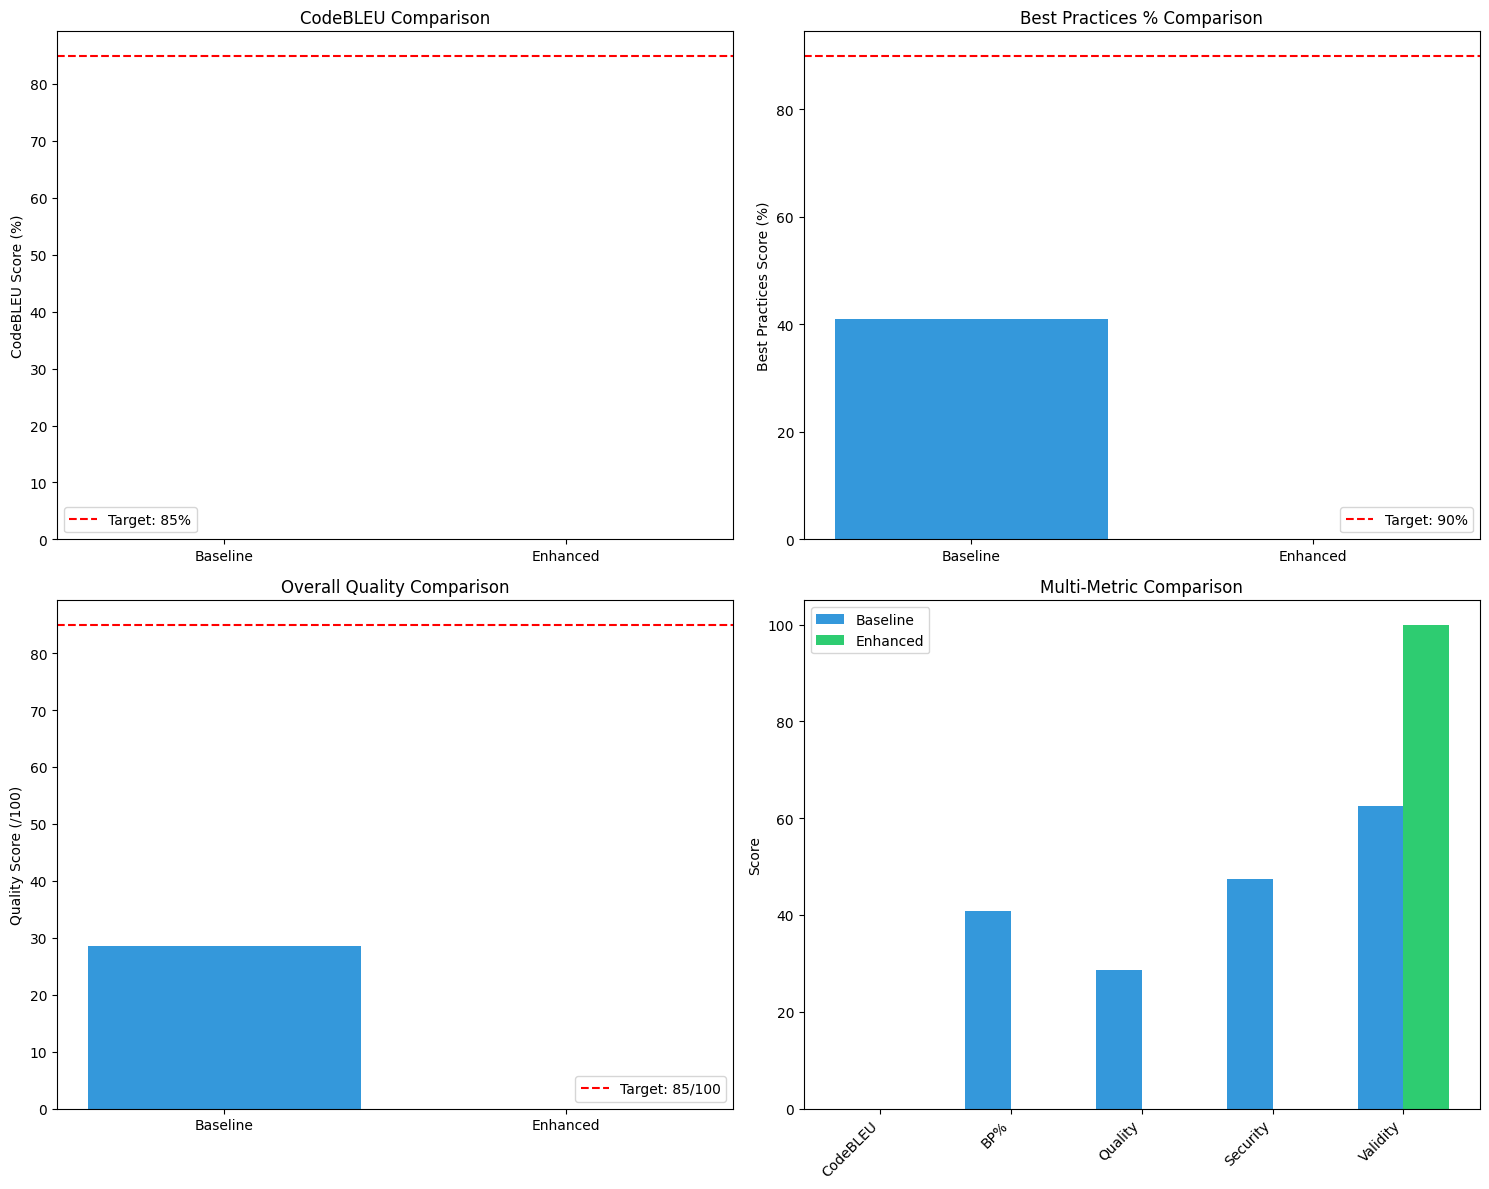


✓ Visualizations saved


In [44]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. CodeBLEU Comparison
ax = axes[0, 0]
models = ['Baseline', 'Enhanced']
codebleu_means = [
    baseline_summary['codebleu_mean'],
    enhanced_summary['codebleu_mean']
]
ax.bar(models, codebleu_means, color=['#3498db', '#2ecc71'])
ax.axhline(y=85, color='r', linestyle='--', label='Target: 85%')
ax.set_ylabel('CodeBLEU Score (%)')
ax.set_title('CodeBLEU Comparison')
ax.legend()

# 2. Best Practices % Comparison
ax = axes[0, 1]
bp_means = [
    baseline_summary['bp_mean'],
    enhanced_summary['bp_mean']
]
ax.bar(models, bp_means, color=['#3498db', '#2ecc71'])
ax.axhline(y=90, color='r', linestyle='--', label='Target: 90%')
ax.set_ylabel('Best Practices Score (%)')
ax.set_title('Best Practices % Comparison')
ax.legend()

# 3. Quality Score Comparison
ax = axes[1, 0]
quality_means = [
    baseline_summary['quality_mean'],
    enhanced_summary['quality_mean']
]
ax.bar(models, quality_means, color=['#3498db', '#2ecc71'])
ax.axhline(y=85, color='r', linestyle='--', label='Target: 85/100')
ax.set_ylabel('Quality Score (/100)')
ax.set_title('Overall Quality Comparison')
ax.legend()

# 4. Multi-metric Radar Chart
ax = axes[1, 1]
categories = ['CodeBLEU', 'BP%', 'Quality', 'Security', 'Validity']
baseline_values = [
    baseline_summary['codebleu_mean'],
    baseline_summary['bp_mean'],
    baseline_summary['quality_mean'],
    baseline_summary['security_mean'],
    baseline_summary['validity_rate']
]
enhanced_values = [
    enhanced_summary['codebleu_mean'],
    enhanced_summary['bp_mean'],
    enhanced_summary['quality_mean'],
    enhanced_summary['security_mean'],
    enhanced_summary['validity_rate']
]

x = np.arange(len(categories))
width = 0.35
ax.bar(x - width/2, baseline_values, width, label='Baseline', color='#3498db')
ax.bar(x + width/2, enhanced_values, width, label='Enhanced', color='#2ecc71')
ax.set_ylabel('Score')
ax.set_title('Multi-Metric Comparison')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig(f'{RESULTS_PATH}/comparison_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations saved")

## 10. Save Final Results

In [ ]:
# Compile final results
final_results = {
    'timestamp': datetime.now().isoformat(),
    'model_info': {
        'architecture': 'Dual-Encoder CodeT5 with RL',
        'base_model': 'Salesforce/codet5-base',
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'training_stages': ['Supervised Fine-tuning', 'RL Optimization']
    },
    'baseline': baseline_summary,
    'enhanced': enhanced_summary,
    'statistical_tests': stat_results,
    'targets_achieved': {
        'codebleu_target_85': enhanced_summary['codebleu_mean'] >= 85,
        'bp_target_90': enhanced_summary['bp_mean'] >= 90,
        'quality_target_85': enhanced_summary['quality_mean'] >= 85
    }
}

# Save results
with open(f'{RESULTS_PATH}/phase2_final_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': model.config,
    'results': final_results
}, f'{ENHANCED_MODEL_PATH}/final_enhanced_model.pt')

print("\n" + "="*60)
print("PHASE 2 COMPLETE!")
print("="*60)
print(f"\nResults saved to: {RESULTS_PATH}")
print(f"Model saved to: {ENHANCED_MODEL_PATH}")

# Print summary
print("\n📊 FINAL SUMMARY:")
print(f"\nBaseline Performance:")
print(f"  CodeBLEU: {baseline_summary['codebleu_mean']:.2f}%")
print(f"  BP%:      {baseline_summary['bp_mean']:.2f}%")
print(f"  Quality:  {baseline_summary['quality_mean']:.2f}/100")

print(f"\nEnhanced Performance:")
print(f"  CodeBLEU: {enhanced_summary['codebleu_mean']:.2f}% {'✓' if enhanced_summary['codebleu_mean'] >= 85 else '✗'}")
print(f"  BP%:      {enhanced_summary['bp_mean']:.2f}% {'✓' if enhanced_summary['bp_mean'] >= 90 else '✗'}")
print(f"  Quality:  {enhanced_summary['quality_mean']:.2f}/100 {'✓' if enhanced_summary['quality_mean'] >= 85 else '✗'}")

print(f"\n🎯 Targets: CodeBLEU ≥85%, BP% ≥90%, Quality ≥85/100")
targets_met = sum(final_results['targets_achieved'].values())
print(f"   Status: {targets_met}/3 targets achieved")

## 11. Next Steps

### Phase 3 (Weeks 7-8): Evaluation & Thesis Writing

1. **Comprehensive Evaluation** (4 days)
   - Expanded test set evaluation
   - Ablation studies (contribution of each component)
   - Error analysis

2. **User Study** (3 days)
   - Gather feedback from DevOps engineers
   - Evaluate practical utility
   - Assess feedback quality

3. **Thesis Documentation** (remaining time)
   - Results & analysis
   - Discussion
   - Conclusions & future work

### Key Contributions to Highlight:

1. **Architectural Innovation**: First dual-encoder approach for IaC generation
2. **RL Optimization**: Novel reward function based on domain-specific quality metrics
3. **Actionable Feedback**: Transforms generation into education
4. **Empirical Validation**: Systematic comparison with statistical significance testing